In [50]:
import os
import sys
import h5py

### Problem and ACTeN code imports ###
source_path = os.path.join("src/environments/")
sys.path.insert(0,source_path)
import asep_model as am
source_path = os.path.join("src/approximations/")
sys.path.insert(0,source_path)
import value_mps as vm
import policy_mps_asep as pm
source_path = os.path.join("src/")
sys.path.insert(0,source_path)
import actor_critic as ac
import observations as obs
import evaluate_policy as evaluation

### JAX imports ###
import jax.numpy as jnp
from jax import jit
from jax import random
import numpy as np
import jax.config as jax_config
jax_config.update("jax_enable_x64", True)
jax_config.update("jax_debug_nans", True)

## Plotting imports ##
import matplotlib.pyplot as plt

In [51]:
key = random.PRNGKey(123)
SITES = 10
BIAS = -2
VALUE_BOND_DIM = 4
POLICY_BOND_DIM = 16
P_VAL = 0.1
environment_args = dict(
	L = SITES,
	s = BIAS,
	p = P_VAL,
	N = int(SITES/2),
	q = 1 - P_VAL,
)
key, subkey = random.split(key)
state = random.randint(subkey, (SITES,), 0, 2)
key, subkey = random.split(key)
value_params = random.normal(subkey, (2, VALUE_BOND_DIM, VALUE_BOND_DIM))*0.45
# value_params = jnp.array([jnp.identity(VALUE_BOND_DIM), jnp.identity(VALUE_BOND_DIM)])
key, subkey = random.split(key)
policy_params = random.normal(subkey, (2, 2, POLICY_BOND_DIM, POLICY_BOND_DIM))*0.2
key, subkey = random.split(key)


In [52]:
initial_state = jnp.array([0]*int(SITES/2) + [1]*int(SITES/2)) #half filling
key, subkey = random.split(key)
initial_state = random.shuffle(subkey, initial_state, axis=0)

/home/ed/anaconda3/envs/coax_rl/lib/python3.10/site-packages/jax/_src/random.py:386: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


In [53]:
obs_func = obs.observation_vec_to_func(
	[obs.average_reward_observation,
	 am.current_observation, 
	 am.kl_divergence_observation],
	[0, 0.0003, 0.0003]
)
initial_av_rew = 0.0
initial_obs = jnp.array([initial_av_rew, 0.0, 0.0])
LR_PI = 1e-2
LR_VF = 1e-3
LR_R = 1e-3
alg_step = ac.init_actor_critic(
	am.reward_func,
	am.step,
	environment_args,
	vm.value,
	LR_PI,
	pm.policy,
	LR_VF,
	LR_R,
	obs_func
)

In [54]:
train = jit(ac.train, static_argnums=(4,5,7))

In [55]:
number_of_saves = 1000
save_frequence = 100
total_steps = number_of_saves*save_frequence

In [56]:
final_state, _, _, policy_params_opt, _, observations = train(
    initial_state, key, value_params, policy_params, alg_step, 
    number_of_saves, initial_obs, save_frequence, initial_av_rew)

In [57]:
EXACT_DATA_PATH = os.path.join("..", "exact_diagonalization","periodic_asep_ED_-3.0_to_3.0.hdf5")

with h5py.File(EXACT_DATA_PATH, "r") as f:

    group_keys = list(f.keys())
    
    # Get the data
    biases_exact = np.array(list(f[group_keys[0]]))
    biases_exact = biases_exact[-1::-1]
    data_exact = np.array(list(f[group_keys[1]]))
    lattice_sizes_exact = np.array(list(f[group_keys[2]]))
    q_vals = np.array(list(f[group_keys[3]]))

In [58]:
bias_idx = list(biases_exact).index(BIAS)
lattice_idx = list(lattice_sizes_exact).index(SITES)
q_idx = list(q_vals).index(1-P_VAL)

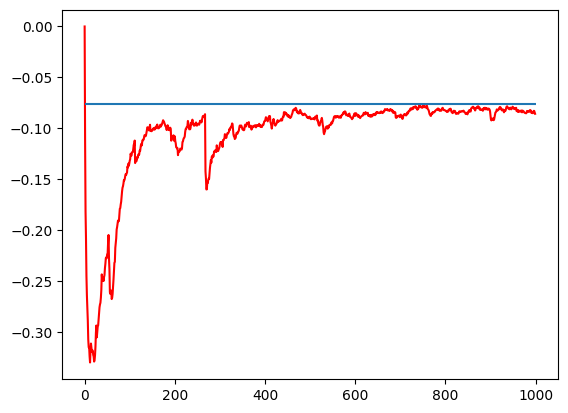

In [59]:
# Learning Curve
fig_lcs = plt.figure()
plt.plot(observations[:,0], "r-")
plt.hlines(data_exact[q_idx,bias_idx,lattice_idx], 0, len(observations[:,0]))

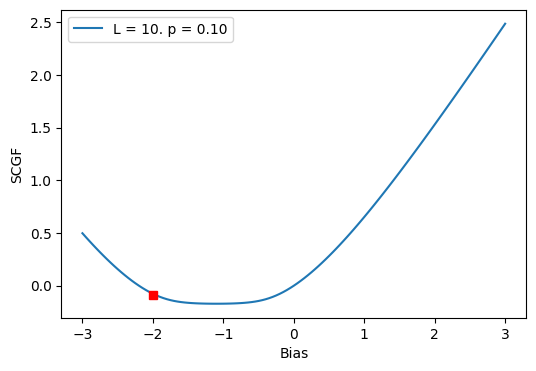

In [60]:
# Final Training Estimate
fig = plt.figure(figsize=(6,4))
plt.plot(biases_exact, data_exact[q_idx,:,lattice_idx], label=f"L = {lattice_sizes_exact[lattice_idx]}. p = {1-q_vals[q_idx]:.2f}")
plt.plot([BIAS],[observations[-1,0]], "rs")
plt.xlabel("Bias")
plt.ylabel("SCGF")
plt.legend()

In [61]:
def obs_func_evaluation(
    observation_state, step,
    prior_state, policy_params, average_reward_eval,
    log_prob, action, state, reward,
    environment_args_eval
    ):
    """Defines the obs_func for evaluation
    """
    learning_rate = 1 # when = 1, no averaging, just return the ob
    pol_grad = 0.0
    val_grad = 0.0
    prior_value = 0.0
    current_value = 0.0
    td_error = 0.0
    value_params = 0.0

    params = (step, learning_rate, prior_state, policy_params, value_params, average_reward_eval, log_prob,
    action, state, pol_grad, val_grad, prior_value,
    current_value, reward, td_error,
    environment_args_eval)

    observation_state = observation_state.at[0].set(reward)
    observation_state = observation_state.at[1].set(am.activity_observation(observation_state[1], *params))
    observation_state = observation_state.at[2].set(am.kl_divergence_observation(observation_state[2], *params))
    observation_state = observation_state.at[3].set(am.current_observation(observation_state[3], *params))
    return observation_state

In [65]:
NUM_EVAL_STEPS = 100000

eval_step = evaluation.init_evaluate(am.reward_func,
        am.step,
        environment_args,
        pm.policy,
        obs_func_evaluation
        )

initial_av_rew_eval  = 0.0
initial_obs_evaluation = jnp.array([0.0, 0.0, 0.0, 0.0])

eval_func = jit(lambda params, initial_state: evaluation.evaluate(params,
    initial_state, key, eval_step,
    NUM_EVAL_STEPS, initial_obs_evaluation, 1, initial_av_rew_eval))

In [66]:
_, _, _, eval_average_reward, eval_observations = eval_func(policy_params_opt, final_state)

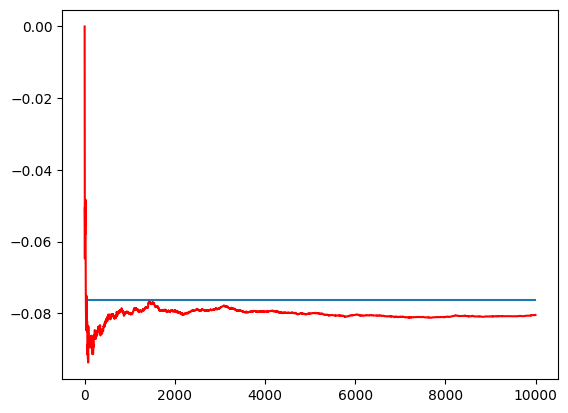

In [ ]:
# Evaluated Optimal Policy
fig_eval = plt.figure()
plt.hlines(data_exact[q_idx,bias_idx,lattice_idx], 0, NUM_EVAL_STEPS)
plt.plot(np.cumsum(eval_observations[:,0])/np.arange(1,NUM_EVAL_STEPS+1), "r-")